In [1]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
#import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.image import resize
import mat73
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

In [3]:
def unet_v1(pretrained_weights = None,input_size = (400,400,1)):
    
    inputs = Input(input_size)
    
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    #conv4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    #conv5 = Dropout(0.5)(conv5)
    
    
    up6 = UpSampling2D(size = (2,2))(conv5)
    #up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = UpSampling2D(size = (2,2))(conv6)
    #up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    
    up8 = UpSampling2D(size = (2,2))(conv7)
    #up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    
    up9 = UpSampling2D(size = (2,2))(conv8)
    #up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    
    
    up10 = UpSampling2D(size = (2,2))(conv9)
    
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(1, 1, activation = 'relu', padding = 'same')(conv10)
    #conv10 = BatchNormalization()(conv10)
    #conv10 = Conv2D(1, 1, activation = 'relu')(conv10)
   
    model = Model(inputs = inputs, outputs = conv10)
    
    rmsprop = RMSprop(
        learning_rate=0.001,
        momentum=0.9,
        epsilon=1e-08
    )
        
    loss = tf.keras.losses.mse   
    model.compile(optimizer = rmsprop, loss = loss, metrics = ['acc'])
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    #if(pretrained_weights):
    #model.load_weights(pretrained_weights)

    return model

In [4]:
def unet_v2(pretrained_weights = None,input_size = (400,400,1)):
    
    inputs = Input(input_size)
    
    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    #conv4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    #conv5 = Dropout(0.5)(conv5)
    
    
    #up6 = UpSampling2D(size = (2,2))(conv5)
    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    #up7 = UpSampling2D(size = (2,2))(conv6)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    
    #up8 = UpSampling2D(size = (2,2))(conv7)
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    
    #up9 = UpSampling2D(size = (2,2))(conv8)
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2), interpolation = 'bilinear')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    
    
    up10 = UpSampling2D(size = (2,2))(conv9)
    
    conv10 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(1, 1, activation = 'relu', padding = 'same')(conv10)
    #conv10 = BatchNormalization()(conv10)
    #conv10 = Conv2D(1, 1, activation = 'relu')(conv10)
   
    model = Model(inputs = inputs, outputs = conv10)
    
    rmsprop = RMSprop(
        learning_rate=0.001,
        momentum=0.9,
        epsilon=1e-08
    )
        
    loss = tf.keras.losses.mse   
    model.compile(optimizer = rmsprop, loss = loss, metrics = ['acc'])
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    #if(pretrained_weights):
    #model.load_weights(pretrained_weights)

    return model

In [5]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    return c


def unet_v3():
    f = [16, 32, 64, 128, 256]
    inputs = Input((400, 400, 1))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    #outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    
    
    outputs = Conv2D(1, (1, 1), padding="same", activation="relu")(u4)
    
    model = tf.keras.models.Model(inputs, outputs)
    
    rmsprop = tf.keras.optimizers.RMSprop(
        learning_rate=0.001,
        momentum=0.9,
        epsilon=1e-08
    )

    loss = tf.keras.losses.mse

    #model = UNet_v3()
    model.compile(optimizer = rmsprop, loss = loss, metrics = ['acc'])
    model.summary()
    
    
    return model

In [6]:
model_v1 = unet_v1()
model_v2 = unet_v2()
model_v3 = unet_v3()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 400, 400, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 400, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 400, 400, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 400, 400, 64) 256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 400, 400, 64) 36928       batch_normalization_19[0][0]     
____________________________________________________________________________________________

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 400, 1) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 400, 400, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 400, 400, 16) 64          conv2d_44[0][0]                  
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 400, 400, 16) 2320        batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [7]:
X_new = mat73.loadmat('X.mat')
Y_new = mat73.loadmat('Y.mat')

X_new = np.array(X_new['X'])
Y_new = np.array(Y_new['Y'])

#scaler_X = MinMaxScaler((0,255))
#scaler_Y = MinMaxScaler((0,255))

X = np.ndarray((2250,400,400))
Y = np.ndarray((2250,400,400))

for i in range(X_new.shape[2]):
    
    #scaler_X.fit(X_new[:,:,i])
    #scaler_Y.fit(Y_new[:,:,i])
    #X[i,:,:] = scaler_X.transform(X_new[:,:,i])
    #Y[i,:,:] = scaler_Y.transform(Y_new[:,:,i])
    x = X_new[:,:,i]
    y = Y_new[:,:,i]
    
    x[x < 0] = 0
    y[y < 0] = 0
    
    X[i,:,:] = x
    Y[i,:,:] = y
    
X = np.expand_dims(X,axis=3)
Y = np.expand_dims(Y,axis=3)
print(np.shape(X))
print(np.shape(Y))

(2250, 400, 400, 1)
(2250, 400, 400, 1)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(f'X_train, X_test, y_train, y_test = {len(X_train)}, {len(X_test)},{len(y_train)},{len(y_test)}')

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(f'X_train, X_val, X_test, y_train,y_val, y_test = {len(X_train)}, {len(X_val)}, {len(X_test)},{len(y_train)},{len(y_val)},{len(y_test)}')




X_train, X_test, y_train, y_test = 1800, 450,1800,450
X_train, X_val, X_test, y_train,y_val, y_test = 1800, 225, 225,1800,225,225


In [9]:
model_v1.load_weights('unet_finalv1.h5')
model_v2.load_weights('unet_finalv2.h5')
model_v3.load_weights('unet_finalv3.h5')

In [10]:
output_v1 = model_v1.predict(X_test)
output_v2 = model_v2.predict(X_test)
output_v3 = model_v3.predict(X_test)


model_v1.save('unet_finalv1_whole.h5')
model_v2.save('unet_finalv2_whole.h5')
model_v3.save('unet_finalv3_whole.h5')

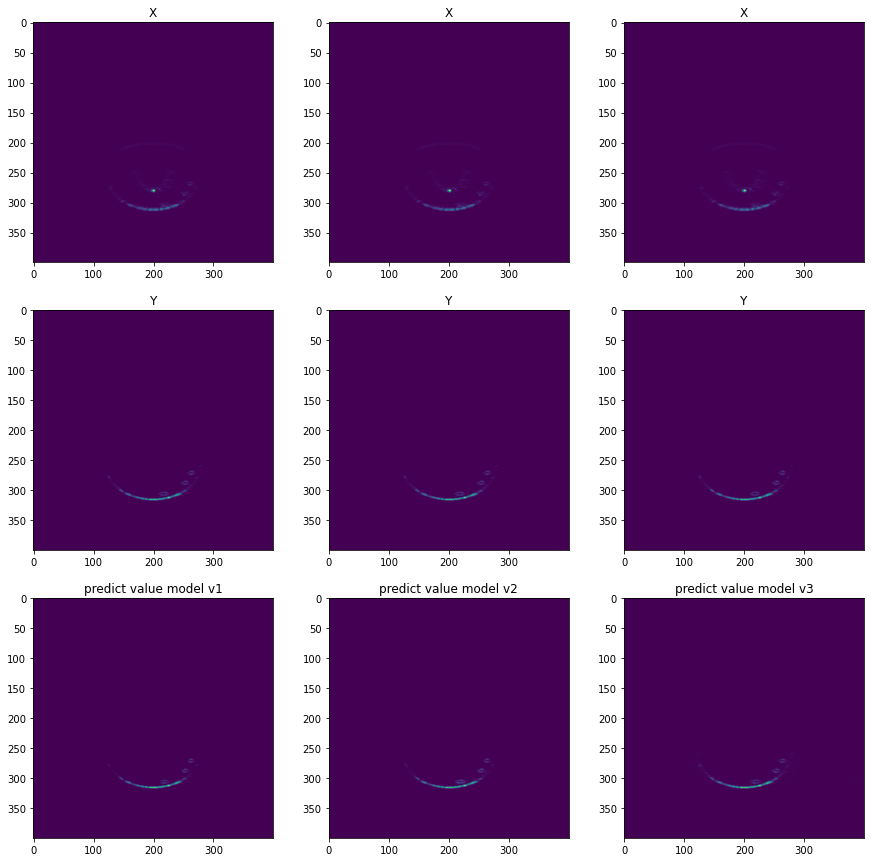

In [13]:
figure, axis = plt.subplots(3, 3, figsize=(15,15))

#d = [1,2,3]
models = [output_v1,output_v2,output_v3]


idx = 200

for i in range(3):
    
    
    axis[0, i].imshow(X_test[idx,:,:,:])
    axis[0, i].set_title("X")
    
    axis[1, i].imshow(y_test[idx,:,:,:])
    axis[1, i].set_title("Y")
    
    axis[2, i].imshow(models[i][idx,:,:,:])
    axis[2, i].set_title("predict value model v" + str(i + 1) )
    




In [26]:
Models = [model_v1,model_v2,model_v3]
results = []
for i in range(3):

    result = Models[i].evaluate(X_test, y_test, batch_size=2)
    results.append(result)

113/113 [==============================] - 25s 210ms/step - loss: 399682.0000 - acc: 8.6039e-04


In [27]:
results

[[3369919.5, 0.015936333686113358],
 [3637225.25, 0.01589072309434414],
 [399682.0, 0.0008603889145888388]]

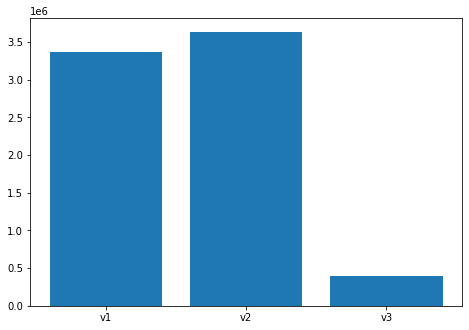

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
inputs = ['v1', 'v2', 'v3']
bars = [results[i][0] for i in range(len(results))]
ax.bar(inputs,bars)
plt.show()